# Amazon Review - Sentiment Analysis

### About Dataset :--

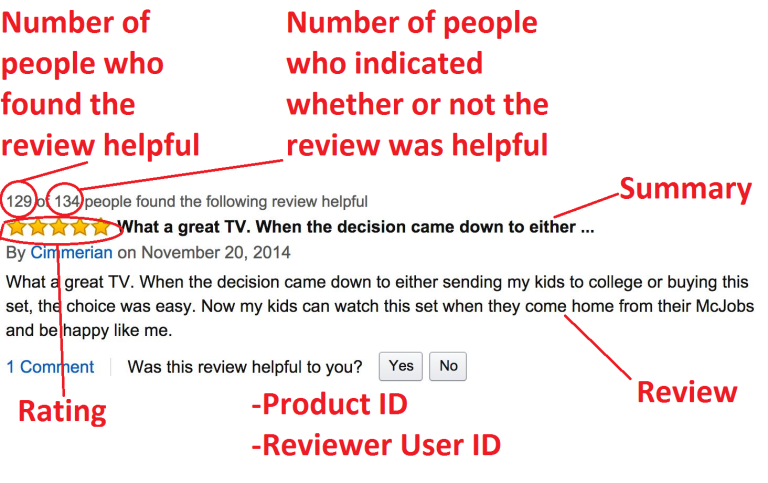

In [9]:
img = Image.open("AmazonReview.png")
img

### The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.
    1. Number of reviews: 568,454
    2. Number of users: 256,059
    3. Number of products: 74,258
    4. Timespan: Oct 1999 - Oct 2012
    5. Number of Attributes/Columns in data: 10

### Attribute Information :-
    1. Id                       -> unique Numeric data for every data
    2. ProductId                -> unique AlphaNumeric data for every product 
    3. UserId                   -> unique AlphaNumeric data for every user
    4. ProfileName              -> Name of user
    5. HelpfulnessNumerator     -> Number of people who foundthe review helpful
    6. HelpfulnessDenominator   -> Number of people who indicated whether or not review is helpful
    7. Score                    -> total number of rating
    8. Time                     -> Oct 1999 - Oct 2012
    9. Summary                  -> textual data about the product(Briefly)
    10. Text                    -> textual data about the product(Review)

# Problem Statement
#### Given review, determine whether the review is positive or negative

In [10]:
# import libraries

# Data Manipulation & Visualization
import re
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
# TEXT - PREPROCESSING
from bs4 import BeautifulSoup
from wordcloud import STOPWORDS

# ML-Model 
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# For Tuning model
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

# performance Metrics
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix

In [39]:
# read csv file 
review = pd.read_csv('Reviews.csv')
review.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [40]:
# Columns of dataset

review.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [41]:
# Shape of Dataset

review.shape

(568454, 10)

### Observation
    number of rows = 568454 
    number of columns = 10


In [42]:
# Checking null Values

review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


### Observation 
    As we can see there is no null values.

In [43]:
# Checking either dataset is balanced or not
# Checking the number of datapoints for each score

review.Score.value_counts()

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

### Observation :--
    1. least rating is "1" and Highest rating is "5"
    2. Maximum number of datapoint is for "5" - is positive review

In [44]:
# Checking if there is any duplicate value in dataset

duplicate_reviews = review[review.duplicated(subset=['UserId','ProfileName','Time','Text'],keep=False)]
duplicate_reviews.shape

(232415, 10)

In [45]:
duplicate_reviews[duplicate_reviews['UserId'] == 'AI3Y26HLPYW4L']

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
350961,350962,B0018CLVE8,AI3Y26HLPYW4L,kimosabe,1,2,2,1330041600,premium edge cat food,My cats don't like it. what else can I say to ...
568413,568414,B0018CLWM4,AI3Y26HLPYW4L,kimosabe,1,2,2,1330041600,premium edge cat food,My cats don't like it. what else can I say to ...


In [46]:
# Remove duplicate review - keep first entry and rest will be deleted
# df.duplicate(subset=[column name].keep = "first/second/false")
# df.drop_duplicate(subset = [column name],keep = "first/second/false")

# keep = 'first' --> will keep the first review and restof duplicate value will be dropped
# keep = 'second' --> will keep the second review and restof duplicate value will be dropped
# keep = 'false' --> will drop all duplicate values

reviews = review.drop_duplicates(subset=['UserId','ProfileName','Time','Text'],keep = "first",inplace = False)
reviews.shape

(393933, 10)

In [47]:
reviews.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [48]:
#Checking to see how much % of data still remains
print("Remaining data is",((reviews.shape[0]*1.0)/(review.shape[0]*1.0))*100)

Remaining data is 69.29901100176971


## Explore Dataset

In [49]:
# step1: Distribution of review - I first looked at the
#distribution of ratings among all of the reviews.

reviews.Score.value_counts(1)

5    0.637068
4    0.142395
1    0.092163
3    0.075569
2    0.052806
Name: Score, dtype: float64

### Observation :--
    --> 5-star reviews constitute a large proportion (63.7%) of all reviews. 
    --> The next most prevalent rating is 4-stars(14.2%), followed by 1-star (9.2%), 3-star (7.5%), 
    --> and finally 2-star reviews (5.2%)


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


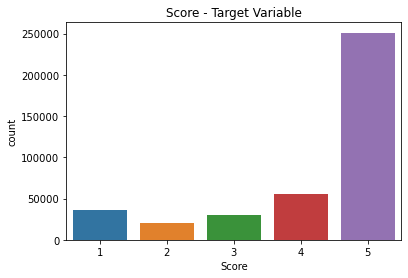

In [50]:
sns.countplot(reviews.Score)
plt.title("Score - Target Variable")
plt.show()

In [51]:
# Score = 1 --> if score>3 (+ve review)
# Score = 0 --> of score<3 (-ve review)

score = review['Score'].apply(lambda x: 1 if x>3 else 0)
reviews['Score'] = score
reviews.head(3)

C:\Users\HP\AppData\Local\Temp\ipykernel_2808\2023238669.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['Score'] = score


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [52]:
positive_review = reviews.Text[reviews["Score"] == 1]

In [53]:
from wordcloud import WordCloud,STOPWORDS

review_words = ""
stopwords = set(STOPWORDS)
for review in tqdm(positive_review):
    review = str(review)
    token = review.split()
    for idx in range(0,len(token)):
        token[idx] = token[idx].lower()
    review_words += " ".join(token)+" "    # +" " include all words, alphabets and symbols present in review 

100%|█████████████████████████████████████████████████████████████████████████| 307056/307056 [13:36<00:00, 376.10it/s]


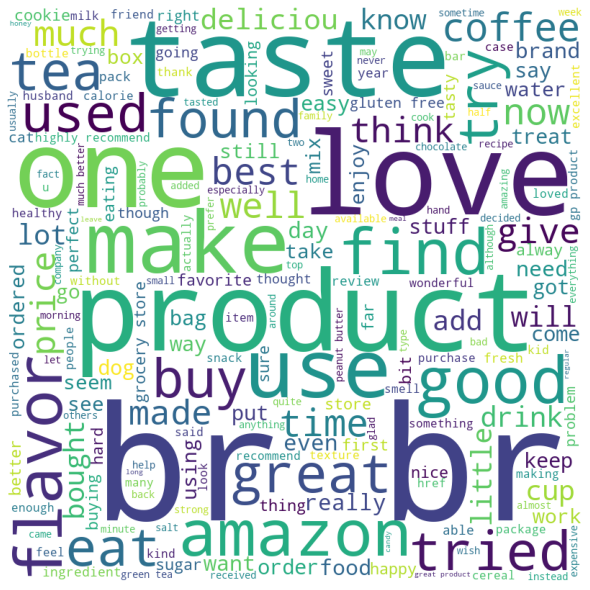

In [54]:
word_cloud = WordCloud(width = 800,height = 800,background_color = "white", stopwords = stopwords,min_font_size = 10).generate(review_words)
plt.figure(figsize = (8,8),facecolor = None)
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [55]:
neg_rev = reviews.Text[reviews["Score"] == 0]

In [56]:
negative_review = ""
for review in tqdm(neg_rev):
    review =str(review)
    token = review.split()
    for i in range(0,len(token)):
        token[i] = token[i].lower()
    negative_review += " ".join(token) + " "    

100%|██████████████████████████████████████████████████████████████████████████| 86877/86877 [01:17<00:00, 1125.00it/s]


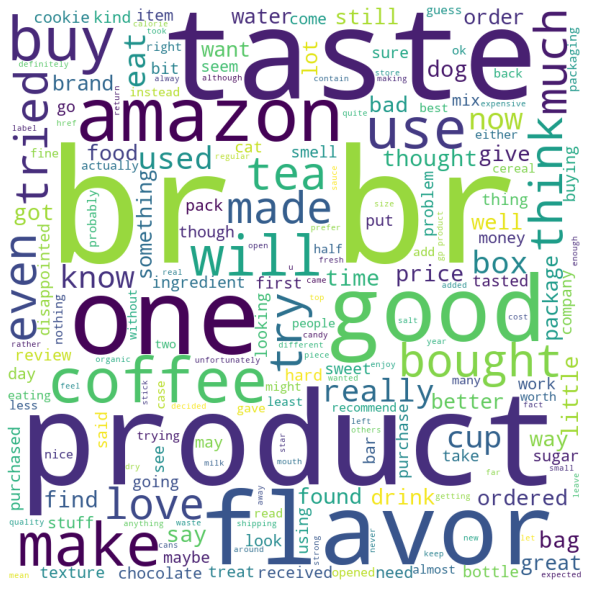

In [57]:
negative_wordcloud = WordCloud(width = 800,height = 800,background_color = "white",stopwords = stopwords,min_font_size = 10).generate(negative_review)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(negative_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

# Analysis of Review Over Time

In [58]:
# Convert Time into date
reviews["Date"] = pd.to_datetime(reviews["Time"],unit = 's')

# Create a new dataframe   which comprises of date, text and score
df = reviews[["Date","Text","Score"]]

# Consider only Year and month
df["Date"] = df.Date.dt.strftime("%Y-%m")
df.head(2)

C:\Users\HP\AppData\Local\Temp\ipykernel_2808\2856638809.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = df.Date.dt.strftime("%Y-%m")


,Date,Text,Score
0,2011-04,I have bought several of the Vitality canned d...,1
1,2012-09,Product arrived labeled as Jumbo Salted Peanut...,0


In [59]:
# Sort dataFrame by date
df = df.sort_values(by = ["Date"]).reset_index(drop = True)

# Get distinct dataframe as per score
df_1 = df[df["Score"] == 1]
df_0 = df[df["Score"] == 0]

# Groupby dataframe w.r.t date and score
df_1 = df_1.groupby('Date')["Score"].count().reset_index()
df_1.head(2)

,Date,Score
0,1999-10,2
1,1999-12,2


In [60]:
df_0 = df_0.groupby("Date")["Score"].count().reset_index()
df_0.head(2)

,Date,Score
0,2000-01,1
1,2001-05,1


In [62]:
import plotly.graph_objects as go
from plotly.offline import iplot

# dict for the dataframe and their names
dfs = {"Positive_Review" : df_1,
      "Negative_Review" : df_0}

# plot the data
fig = go.Figure()

for i in dfs:
    fig = fig.add_trace(go.Scatter(x = dfs[i]["Date"],
                                  y = dfs[i]["Score"],
                                  name = i))

fig.update_layout(title = "Review Trend From 1999 - 2012",
                 xaxis_title = "Date",
                 yaxis_title = "Number of reviews")
fig.show()

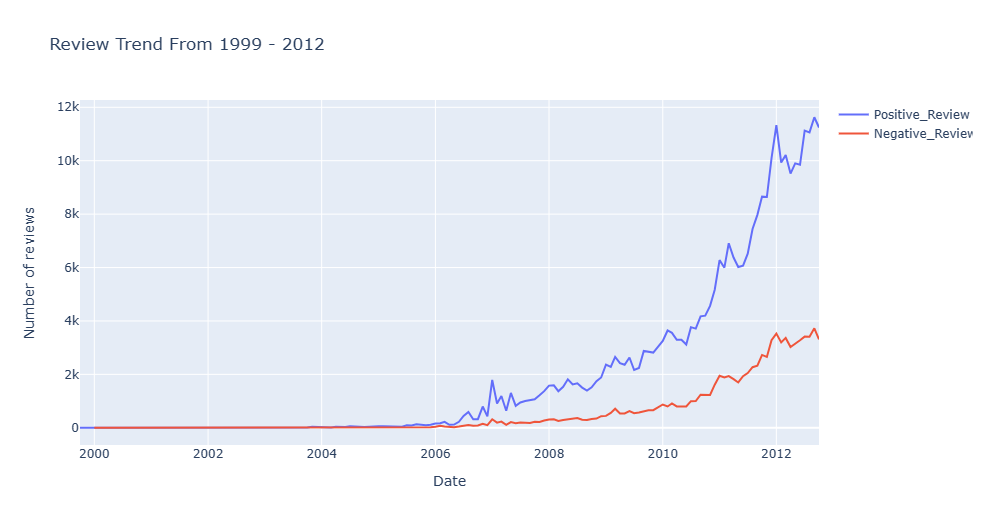

In [63]:
img = Image.open("newPlot.png")
img

#### Observation:
1. From 2000 to late 2005 the positive and negative reviews remain constant to 0.
2. From late 2005 - 2012 there is gradually increase in reviews.
3. Positive reviews are increasing faster than negative reviews.
4. Reason: Lack of awareness among the people about online food shopping.
5. May be people are less active in providing reviews

# Analysis of Score(Target Variable)

In [21]:
reviews.Score.value_counts()

1    307056
0     86877
Name: Score, dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



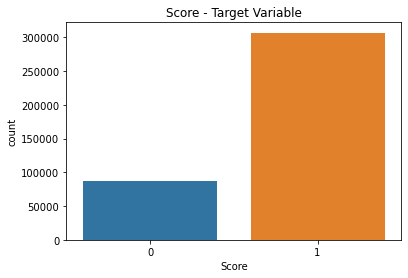

In [22]:
sns.countplot(reviews.Score)
plt.title("Score - Target Variable")
plt.show()

### Observation:
1. Score - is an imbalance dataset
2. We cannot use accuracy as performance matrics because "Score" is imbalanced.
3. We can use AUC-ROC Curve as performance metrics.
4. AUC is the area under ROC curve.It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. The ROC curve is plotted with TPR against the FPR where TPR is on y-axis and FPR is on the x-axis.

# Analysis on ProductId and UserId

In [23]:
# we will see the product bought by each customer

purchase = reviews[["ProductId","UserId"]].groupby(by = "UserId").count().reset_index()
purchase.columns = ["User_id","No. of product purchased"]

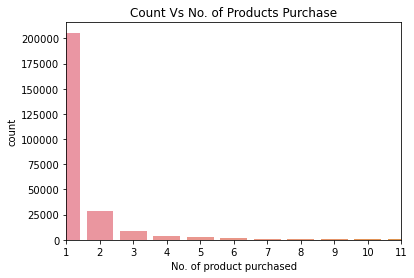

In [24]:
sns.countplot(x = purchase["No. of product purchased"],data = purchase)
plt.xlim(0,10)
plt.title("Count Vs No. of Products Purchase")
plt.show()

In [25]:
purchase.describe()

,No. of product purchased
count,256059.000000
mean,1.538446
std,2.756584
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,329.000000


### Observation :---
    1.Maximum customers purchase only 1 product


# Analysis on Helpfulness

In [28]:
# Helpfulness Numerator(helpfull) - No. of customers who find review helpful
# Helpfulness Denominator(helpfull + not helpfull) -  Number of users who indicated whether they found the review helpful or not
# Helpfulness Numerator > Helpfulness Denominator ---> is not practically possible

reviews[reviews.HelpfulnessNumerator > reviews.HelpfulnessDenominator]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
44736,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,1,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
64421,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,1,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


In [29]:
# drop this row from review dataset
reviews = reviews[reviews["HelpfulnessNumerator"]<=reviews["HelpfulnessDenominator"]]
reviews.shape

(393931, 10)

# Text Preprocessing

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)

In [28]:
# Decontraction of text
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't","will not", phrase)
    phrase = re.sub(r"can\'t","can not", phrase)
    
    # general
    phrase = re.sub(r"n\'t"," not", phrase)
    phrase = re.sub(r"\'re"," are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [29]:
from wordcloud import STOPWORDS

# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords = set(STOPWORDS)
print(stopwords)

{"you're", "i'm", 'after', 'ought', 'then', 'against', 'himself', 'she', "we'd", 'or', 'in', "that's", 'herself', "they'll", 'of', "don't", 'the', 'was', 'www', 'yourself', 'nor', 'more', "he's", 'have', 'most', 'however', 'doing', 'it', 'be', "we're", 'http', 'theirs', 'again', 'com', 'yourselves', 'do', 'but', 'would', "isn't", "there's", 'who', 'having', 'hers', 'get', "it's", 'between', 'there', "she'd", 'below', 'them', 'him', 'ever', 'has', 'until', 'if', 'had', "couldn't", 'since', "let's", 'their', 'which', "you'd", "mustn't", 'does', "can't", 'same', "she'll", 'where', 'shall', 'being', 'by', 'my', 'here', 'over', 'should', "wasn't", 'to', 'its', "you'll", 'while', "you've", "shouldn't", 'whom', 'were', 'before', "weren't", "i've", 'on', "wouldn't", 'such', 'those', 'i', 'therefore', "i'll", 'itself', 'me', 'any', 'cannot', 'too', 'at', 'further', "we'll", 'that', 'his', "haven't", 'some', 'with', 'into', 'they', 'he', "we've", "here's", 'own', 'each', 'not', "who's", "shan't"

In [30]:
# Combining all the above preprocessing

from tqdm import tqdm
preprocessed_reviews = []

# tqdm is for printing the status bar
for sentence in tqdm(reviews['Text'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\s*\d\S*", "",sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ',sentence)
    
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    
    preprocessed_reviews.append(sentence.strip())

  0%|                                                                                       | 0/393931 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.

100%|████████████████████████████████████████████████████████████████████████| 393931/393931 [01:42<00:00, 3837.84it/s]


In [31]:
reviews['Clean_Text'] = preprocessed_reviews
reviews.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Date,Clean_Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27,bought several vitality canned dog food produc...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07,product arrived labeled jumbo salted peanuts p...


In [32]:
final_df = reviews[['Time','Clean_Text','Score']]
final_df.head(2)

,Time,Clean_Text,Score
0,1303862400,bought several vitality canned dog food produc...,1
1,1346976000,product arrived labeled jumbo salted peanuts p...,0


In [33]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393931 entries, 0 to 568453
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Time        393931 non-null  int64 
 1   Clean_Text  393931 non-null  object
 2   Score       393931 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 12.0+ MB


In [34]:
final_df = final_df.dropna(axis=0)
final_df.shape

(393931, 3)

In [35]:
# sorting based on time
final_df['Time'] = pd.to_datetime(final_df['Time'],unit='s')
final_df = final_df.sort_values('Time')
final_df = final_df.reset_index(drop=True)
final_df.head(3)

,Time,Clean_Text,Score
0,1999-10-08,witty little book makes son laugh loud recite ...,1
1,1999-10-25,remember seeing show aired television years ag...,1
2,1999-12-02,beetlejuice well written movie everything exce...,1


# Spliting Dataset into Train, Test and validation

In [36]:
from sklearn.model_selection import train_test_split
x = final_df['Clean_Text']
y = final_df['Score']
x.shape

(393931,)

In [37]:
y.shape

(393931,)

In [38]:
# In the first step we will split the data in training and remaining dataset
x_train, x_test, y_train, y_test = train_test_split(x,y, train_size=0.6,random_state = 42,stratify = y)

print(x_train.shape, y_train.shape)
print(x_test.shape , y_test.shape)

(236358,) (236358,)
(157573,) (157573,)


In [39]:
x_cv, x_tst, y_cv, y_tst = train_test_split(x_test, y_test, test_size = 0.5, random_state = 42, stratify = y_test)

print(x_cv.shape , y_cv.shape)
print(x_tst.shape, y_tst.shape)

(78786,) (78786,)
(78787,) (78787,)


# Important Note:
1. You should always try to fit your model on train data and transform it on test data.
2. Do not try to fit your vectorizer on test data as it can cause data leakage issues.

# Convert Text into vector



### Bag of Words

In [40]:
from sklearn.feature_extraction.text import CountVectorizer

In [41]:
# ngram_range= (1,2)
bow = CountVectorizer()
bow.fit(x_train)
x_train_bow = bow.transform(x_train)
x_cv_bow = bow.transform(x_cv)
x_tst_bow = bow.transform(x_tst)

In [42]:
bow_feature = bow.get_feature_names_out()
print(bow_feature[0:99])

['aa' 'aaa' 'aaaa' 'aaaaa' 'aaaaaaaaaa' 'aaaaaaaaaaa' 'aaaaaaaaaaaa'
 'aaaaaaaaaaaaa' 'aaaaaaaaaaaaaaa' 'aaaaaaaaaaaaaaaaaaaargh' 'aaaaaaah'
 'aaaaaaahhhhhh' 'aaaaaaarrrrrggghhh' 'aaaaaah' 'aaaaaahhh' 'aaaaaahhhh'
 'aaaaaahhhhh' 'aaaaaahhhhhyaaaaaa' 'aaaaaawwwwwwwwww' 'aaaaah'
 'aaaaahhhhhhhhhhhhhhhh' 'aaaaallll' 'aaaahhhhhh' 'aaaahhhhhhhhhhh'
 'aaaand' 'aaaannnnddd' 'aaaarrrrghh' 'aaah' 'aaahhhhhh' 'aaahhhs' 'aaahs'
 'aabout' 'aachener' 'aacurate' 'aad' 'aadmit' 'aadp' 'aadults' 'aaf'
 'aafco' 'aafes' 'aagh' 'aah' 'aahhed' 'aahhhs' 'aahing' 'aahs' 'aain'
 'aalmost' 'aaloo' 'aalouisiana' 'aamazon' 'aamzon' 'aana' 'aand'
 'aanother' 'aany' 'aap' 'aare' 'aaron' 'aaround' 'aarp' 'aarrgghhhh'
 'aarthur' 'aas' 'aash' 'aauces' 'ab' 'aback' 'abalone' 'abalones'
 'abamectin' 'abandned' 'abandon' 'abandoned' 'abandoning' 'abandons'
 'abash' 'abated' 'abates' 'abb' 'abba' 'abbazabba' 'abberline' 'abbey'
 'abbie' 'abbot' 'abbott' 'abbotts' 'abbreviated' 'abbreviating'
 'abbreviation' 'abby' 'abby

In [43]:
print(x_train_bow.shape, x_cv_bow.shape)

(236358, 93831) (78786, 93831)


# Naive Bayes on Bag of Words 

In [44]:
# Optimal alpha - hyperparameter tunning 

In [45]:
train_auc = []
cv_auc = []
alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
for param in alpha:
    naive = MultinomialNB(alpha=param)             
    naive.fit(x_train_bow,y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    y_train_pred =  naive.predict_proba(x_train_bow)[:,1]
    y_cv_pred =  naive.predict_proba(x_cv_bow)[:,1] 
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

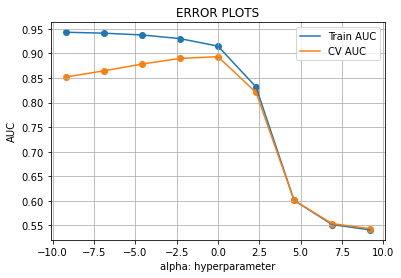

In [46]:
#plotting
plt.grid(True)
plt.plot(np.log(alpha), train_auc, label='Train AUC')
plt.plot(np.log(alpha), cv_auc, label='CV AUC')
plt.scatter(np.log(alpha), train_auc)
plt.scatter(np.log(alpha), cv_auc)
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [47]:
# from GRID SEARCH CROSS VALIDATION finding value of optimal alpha
from sklearn.model_selection import GridSearchCV

alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
param = {"alpha" : alpha}
naive = MultinomialNB()
clf = GridSearchCV(naive, param)
clf.fit(x_train_bow,y_train)
GridSearchCV(estimator = naive,
            param_grid = param)
clf.best_estimator_

MultinomialNB(alpha=1)

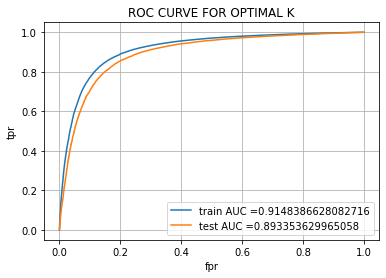

Area under train roc 0.9148386628082716
Area under test roc 0.893353629965058


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



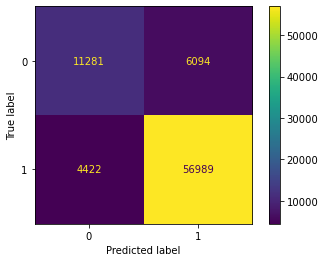

In [48]:
optimal_alpha = 1
naive_opt = MultinomialNB(alpha=optimal_alpha)
naive_opt = naive_opt.fit(x_train_bow,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, naive_opt.predict_proba(x_train_bow)[:,1])
cv_fpr, cv_tpr, thresholds = roc_curve(y_cv, naive_opt.predict_proba(x_cv_bow)[:,1])

#plotting
plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(cv_fpr, cv_tpr, label="test AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
NB_Train = auc(train_fpr, train_tpr)
print('Area under train roc {}'.format(NB_Train))
NB_CV = auc(cv_fpr, cv_tpr)
print('Area under test roc {}'.format(NB_CV))
plot_confusion_matrix(naive_opt,x_cv_bow,y_cv)

## Logistic Regression on BOW

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_ba

Model with best parameters :
 {'C': 0.1, 'penalty': 'l2'}


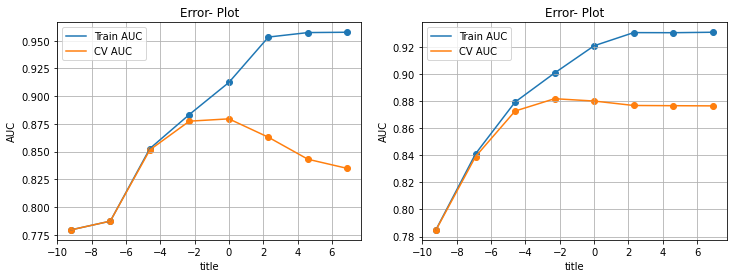

In [49]:
penalty = ['l1','l2']
C = [0.0001,0.001,0.01,0.1,1,10,100,1000]

grid={"penalty":penalty,"C":C}
logreg=LogisticRegression(solver='liblinear')
model=GridSearchCV(logreg,grid,cv=5,return_train_score=True)
model.fit(x_train_bow,y_train)

print("Model with best parameters :\n",model.best_params_)

f, axes = plt.subplots(1, 2,figsize=(12,4))

for i in range(2):
    title = 'log - L1 penalty - hyperparameter' if i ==0 else 'log - L2 penalty hyperparameter'
    train_auc = model.cv_results_['mean_train_score'][0+i:16+i:2]
    cv_auc = model.cv_results_['mean_test_score'][0+i:16+i:2]
    axes[i].plot(np.log(C), train_auc, label='Train AUC')
    axes[i].plot(np.log(C), cv_auc, label='CV AUC')
    axes[i].scatter(np.log(C), train_auc)
    axes[i].grid(True)
    axes[i].legend()
    axes[i].scatter(np.log(C), cv_auc)
    axes[i].set_xlabel(title)
    axes[i].set_ylabel("AUC")
    axes[i].set_title("Error- Plot")
    
plt.show()    

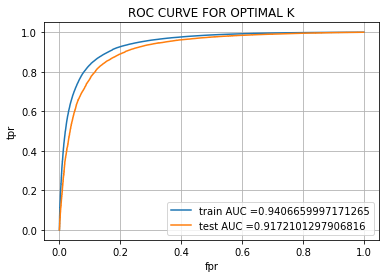

Area under train roc 0.9406659997171265
Area under test roc 0.9172101297906816


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



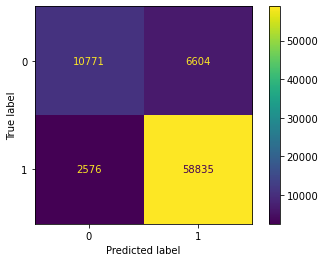

In [50]:
clf_l1_opt = LogisticRegression(**model.best_params_,solver='liblinear')
clf_l1_opt = clf_l1_opt.fit(x_train_bow,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_l1_opt.predict_proba(x_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_cv, clf_l1_opt.predict_proba(x_cv_bow)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
LR_Train = auc(train_fpr, train_tpr)
print('Area under train roc {}'.format(LR_Train))
LR_CV = auc(test_fpr, test_tpr)
print('Area under test roc {}'.format(LR_CV))
plot_confusion_matrix(clf_l1_opt,x_cv_bow,y_cv)

## SVM

Model with best parameters :
 {'alpha': 0.001, 'penalty': 'l2'}


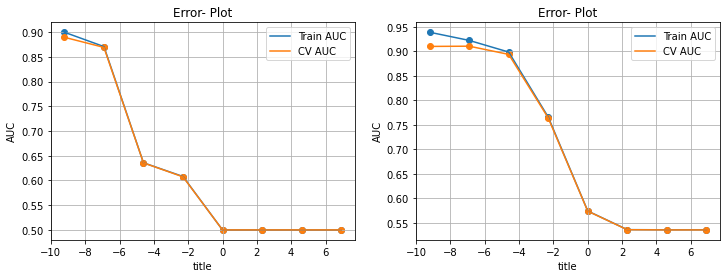

In [51]:
Alpha = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000] 
penalty = ['l1', 'l2']
opt = SGDClassifier()
parameters = {'alpha':Alpha,'penalty':penalty}
model = GridSearchCV(SGDClassifier(), param_grid=parameters,n_jobs=-1, scoring='roc_auc',cv=5, return_train_score=True)
model.fit(x_train_bow,y_train)
print("Model with best parameters :\n",model.best_params_)

f, axes = plt.subplots(1, 2,figsize=(12,4))

for i in range(2):
    title = 'L1 penalty - hyperparameter' if i ==0 else 'L2 penalty hyperparameter'
    train_auc = model.cv_results_['mean_train_score'][0+i:16+i:2]
    cv_auc = model.cv_results_['mean_test_score'][0+i:16+i:2]
    axes[i].plot(np.log(Alpha), train_auc, label='Train AUC')
    axes[i].plot(np.log(Alpha), cv_auc, label='CV AUC')
    axes[i].scatter(np.log(Alpha), train_auc)
    axes[i].grid(True)
    axes[i].legend()
    axes[i].scatter(np.log(Alpha),cv_auc)
    axes[i].set_xlabel("title")
    axes[i].set_ylabel("AUC")
    axes[i].set_title("Error- Plot")
    
plt.show()    

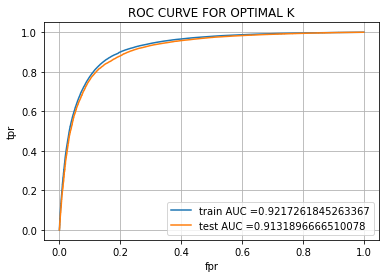

Area under train roc 0.9217261845263367
Area under test roc 0.9131896666510078


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



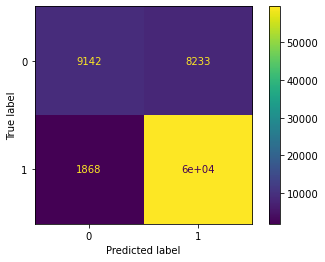

In [52]:
svm_opt = SGDClassifier(**model.best_params_) 
svm_opt.fit(x_train_bow,y_train)
best_est = CalibratedClassifierCV(base_estimator=svm_opt)
best_est = best_est.fit(x_train_bow,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_est.predict_proba(x_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_cv, best_est.predict_proba(x_cv_bow)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
SVM_Train = auc(train_fpr, train_tpr)
print('Area under train roc {}'.format(SVM_Train))
SVM_CV = auc(test_fpr, test_tpr)
print('Area under test roc {}'.format(SVM_CV))
plot_confusion_matrix(svm_opt,x_cv_bow,y_cv)

# Decision Tree

In [53]:
clf = DecisionTreeClassifier()
samplesplits = [5, 10, 100, 500]
maximumdepth = [1, 5, 10, 50, 100, 500, 1000]
parameters = {'min_samples_split':samplesplits ,'max_depth':maximumdepth}
model = GridSearchCV(estimator=clf, param_grid=parameters, cv=3, n_jobs=-1, scoring='roc_auc',return_train_score=True)
model.fit(x_train_bow,y_train)
print("Model with best parameters :\n",model.best_params_)
train_auc = model.cv_results_['mean_train_score'].reshape(7,4)
cv_auc = model.cv_results_['mean_test_score'].reshape(7,4)

Model with best parameters :
 {'max_depth': 50, 'min_samples_split': 500}


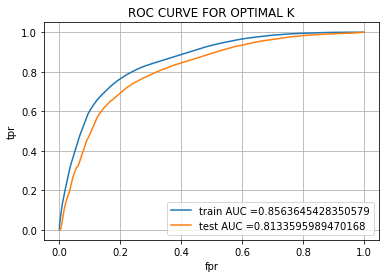

Area under train roc 0.8563645428350579
Area under test roc 0.8133595989470168


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



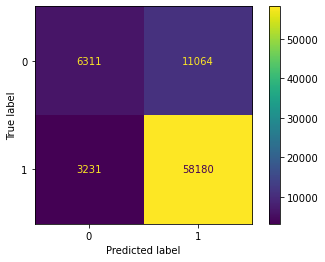

In [54]:
best_est = DecisionTreeClassifier(**model.best_params_)
best_est = best_est.fit(x_train_bow,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_est.predict_proba(x_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_cv, best_est.predict_proba(x_cv_bow)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")   
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
DT_Train = auc(train_fpr, train_tpr)
print('Area under train roc {}'.format(DT_Train))
DT_CV = auc(test_fpr, test_tpr)
print('Area under test roc {}'.format(DT_CV))
plot_confusion_matrix(best_est,x_cv_bow,y_cv)

# Random Forest

Model with best parameters :
 {'max_depth': 30, 'n_estimators': 120}


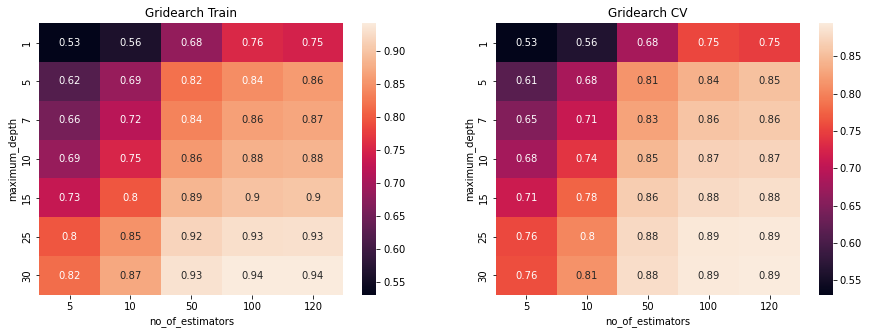

In [55]:
clf = RandomForestClassifier(n_jobs= -1,class_weight='balanced')
no_of_estimators = [5, 10, 50, 100, 120]
maximumdepth = [1, 5, 7, 10, 15, 25, 30]
parameters = {'n_estimators': no_of_estimators ,'max_depth':maximumdepth}
model = GridSearchCV(estimator=clf, param_grid=parameters, cv=5, n_jobs=-1, scoring='roc_auc',return_train_score=True)
model.fit(x_train_bow,y_train)
print("Model with best parameters :\n",model.best_params_)
train_auc = model.cv_results_['mean_train_score'].reshape(7,5)
cv_auc = model.cv_results_['mean_test_score'].reshape(7,5)

f, axes = plt.subplots(1, 2,figsize=(15,5))

for i in range(2):
    title = train_auc if i == 0 else cv_auc
    sns.heatmap(title,xticklabels=no_of_estimators,yticklabels=maximumdepth,annot=True,ax=axes[i])
    axes[i].set_title(f"Gridearch {'Train' if i==0 else 'CV'}")
    axes[i].set_xlabel("no_of_estimators")
    axes[i].set_ylabel("maximum_depth")
    
plt.show()  

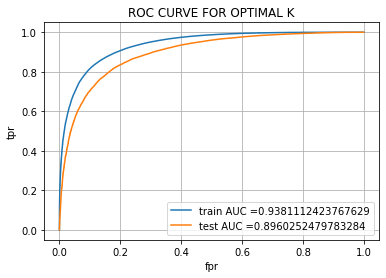

Area under train roc 0.9381112423767629
Area under test roc 0.8960252479783284


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



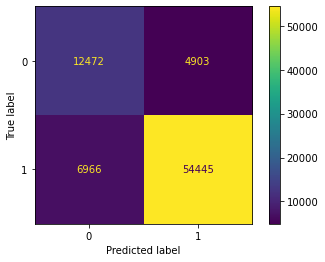

In [56]:
best_est = RandomForestClassifier(**model.best_params_,class_weight='balanced')
best_est = best_est.fit(x_train_bow,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_est.predict_proba(x_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_cv, best_est.predict_proba(x_cv_bow)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
RF_Train = auc(train_fpr, train_tpr)
print('Area under train roc {}'.format(RF_Train))
RF_CV = auc(test_fpr, test_tpr)
print('Area under test roc {}'.format(RF_CV))
plot_confusion_matrix(best_est,x_cv_bow,y_cv)

In [67]:
from wordcloud import WordCloud
dataf = best_est.feature_importances_
features = bow_feature
dataf = pd.DataFrame(dataf,columns=['coef'],index=features)
top = dataf.sort_values(by='coef',ascending=False).head(20)
print('Top 20 features are: \n {}'.format(top))
top['words'] = top.index
top.reset_index(drop=True)
sent = top.words.str.cat(sep=' ') 

Top 20 features are: 
                    coef
delicious      0.004130
highly         0.004080
worst          0.004063
hooked         0.004027
excellent      0.003228
perfect        0.003222
yum            0.003092
threw          0.002909
yummy          0.002870
waste          0.002814
return         0.002809
disappointing  0.002801
yuck           0.002664
awful          0.002646
pleased        0.002551
disappointed   0.002510
amazing        0.002436
horrible       0.002343
refund         0.002316
terrible       0.002216


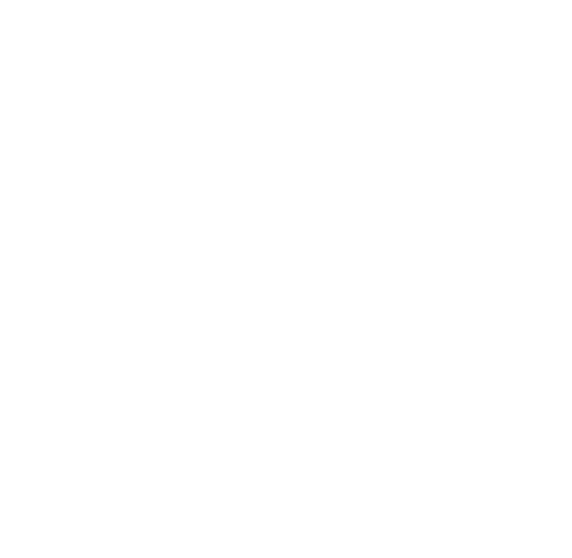

In [68]:
# #word cloud representation
# wordcloud = WordCloud(background_color='white').generate(sent)
# plt.figure(figsize=(10,10))
# plt.axis("off")
# plt.show()

# XGBoost

[22:59:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

Model with best parameters :
 {'max_depth': 30, 'n_estimators': 120}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


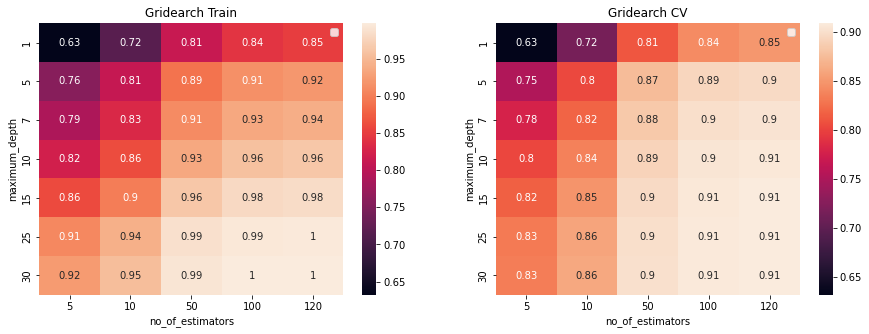

In [57]:
clf = xgb.XGBClassifier(n_jobs= -1,class_weight='balanced')
no_of_estimators = [5, 10, 50, 100, 120]
maximumdepth = [1, 5, 7, 10, 15, 25, 30]
parameters = {'n_estimators': no_of_estimators ,'max_depth':maximumdepth}
model = GridSearchCV(estimator=clf, param_grid=parameters, cv=3, n_jobs=-1, scoring='roc_auc',return_train_score=True)
model.fit(x_train_bow,y_train)
print("Model with best parameters :\n",model.best_params_)
train_auc = model.cv_results_['mean_train_score'].reshape(7,5)
cv_auc = model.cv_results_['mean_test_score'].reshape(7,5)

f, axes = plt.subplots(1, 2,figsize=(15,5))

for i in range(2):
    title = train_auc if i == 0 else cv_auc
    sns.heatmap(title,xticklabels=no_of_estimators,yticklabels=maximumdepth,annot=True,ax=axes[i])
    axes[i].set_title(f"Gridearch {'Train' if i==0 else 'CV'}")
    axes[i].set_xlabel("no_of_estimators")
    axes[i].set_ylabel("maximum_depth")
    axes[i].legend()
    
plt.show()

[23:03:30] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



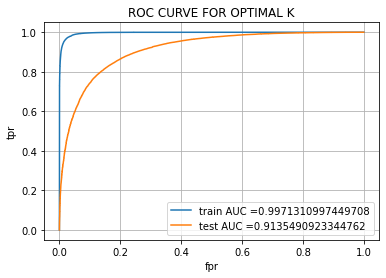

Area under train roc 0.9971310997449708
Area under test roc 0.9135490923344762


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



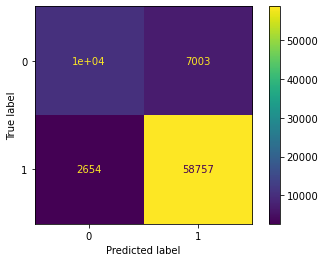

In [58]:
best_est = xgb.XGBClassifier(**model.best_params_,class_weight='balanced')
best_est = best_est.fit(x_train_bow,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_est.predict_proba(x_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_cv, best_est.predict_proba(x_cv_bow)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
XGB_Train = auc(train_fpr, train_tpr)
print('Area under train roc {}'.format(XGB_Train))
XGB_CV = auc(test_fpr, test_tpr)
print('Area under test roc {}'.format(XGB_CV))
plot_confusion_matrix (best_est,x_cv_bow,y_cv)

In [60]:
data = {'Naive_Bayes' : {'Train' : NB_Train, 'Cross_Validation' : NB_CV},
       'Logistic_Regression' : {'Train' : LR_Train,  'Cross_Validation' : LR_CV},
        'Support_Vector_Machine' : {'Train' : SVM_Train,  'Cross_Validation' : SVM_CV},
        'Decision_Tree' : {'Train' : DT_Train,  'Cross_Validation' : DT_CV},
        'Random_forest' : {'Train' : RF_Train,  'Cross_Validation' : RF_CV},
        'XGBoost' : {'Train' : XGB_Train,  'Cross_Validation' : XGB_CV}}



In [70]:
final_df0 = pd.DataFrame(data).T
final_df0.to_csv("ROC-AUC Score of Models.csv")

In [71]:
final_df0

,Train,Cross_Validation
Naive_Bayes,0.914839,0.893354
Logistic_Regression,0.940666,0.917210
Support_Vector_Machine,0.921726,0.913190
Decision_Tree,0.856365,0.813360
Random_forest,0.938111,0.896025
XGBoost,0.997131,0.913549
